In [1]:
import tensorflow as tf
from tensorflow import reshape
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import h5py

print(tf.__version__)

2.0.0


In [2]:
hf = h5py.File('layered-proton-tracks.h5', 'r')

In [3]:
image_width, image_length, image_channels = 128, 128, 3
image_shape = (128,128,3)

In [4]:
data = hf['features']
label = hf['targets']

In [5]:
train_data = data[0:32000]
test_data = data[32000:40000]
train_label = label[0:32000]
test_label = label[32000:40000]

In [6]:
from numpy import expand_dims
train_data=expand_dims(train_data, axis=3)
train_data.shape

(32000, 128, 128, 1)

In [7]:
train_data = np.concatenate((train_data,)*3, axis=-1)
train_data.shape

(32000, 128, 128, 3)

In [8]:
test_data=expand_dims(test_data, axis=3)
test_data.shape

(8000, 128, 128, 1)

In [9]:
test_data=np.concatenate((test_data,)*3, axis=-1)
test_data.shape

(8000, 128, 128, 3)

In [10]:
train_data = train_data.reshape((len(train_data), image_width, image_length, image_channels))

In [11]:
train_data = train_data/255.0
test_data = test_data/255.0

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [13]:
vgg16_model = tf.keras.applications.VGG16(input_shape=image_shape, include_top=False, weights='imagenet')

In [14]:
vgg16_model.trainable=False

In [15]:
CNN_model = tf.keras.Sequential()
CNN_model.add(vgg16_model)
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(250, activation='relu'))
CNN_model.add(layers.Dropout(0.5))
CNN_model.add(layers.Dense(250, activation='relu'))
CNN_model.add(layers.Dropout(0.5))
CNN_model.add(layers.Dense(4, activation='softmax'))

CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [16]:
CNN_history = CNN_model.fit(train_data, train_label, epochs=45,
                           batch_size=32,
                           shuffle=True,
                           callbacks = [callback],
                           validation_split=0.3)

Train on 22400 samples, validate on 9600 samples
Epoch 1/45
22400/22400 [==============================] - 29s 1ms/sample - loss: 0.5924 - accuracy: 0.7797 - val_loss: 0.1061 - val_accuracy: 0.9940
Epoch 2/45
22400/22400 [==============================] - 25s 1ms/sample - loss: 0.1379 - accuracy: 0.9724 - val_loss: 0.0197 - val_accuracy: 0.9986
Epoch 3/45
22400/22400 [==============================] - 25s 1ms/sample - loss: 0.0545 - accuracy: 0.9901 - val_loss: 0.0070 - val_accuracy: 0.9997
Epoch 4/45
22400/22400 [==============================] - 25s 1ms/sample - loss: 0.0275 - accuracy: 0.9954 - val_loss: 0.0034 - val_accuracy: 0.9998
Epoch 5/45
22400/22400 [==============================] - 25s 1ms/sample - loss: 0.0170 - accuracy: 0.9973 - val_loss: 0.0023 - val_accuracy: 0.9998
Epoch 6/45
22400/22400 [==============================] - 25s 1ms/sample - loss: 0.0119 - accuracy: 0.9982 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 7/45
22400/22400 [==============================] -

In [17]:
result = CNN_model.evaluate(test_data, test_label, verbose=2)

8000/1 - 6s - loss: 4.6399e-04 - accuracy: 0.9996


In [18]:
predictions = np.argmax(CNN_model.predict(test_data[:]),axis=1)

In [19]:
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2633
           2       1.00      1.00      1.00      2693
           3       1.00      1.00      1.00      2674

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



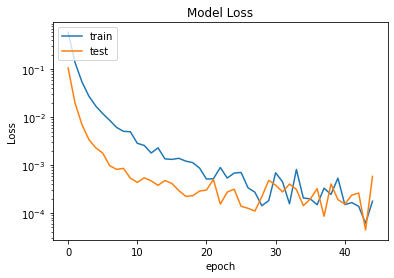

In [21]:
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model Loss')
plt.yscale("log")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools

In [23]:
cm = confusion_matrix(test_label, predictions)

In [24]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         include_values=True,
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

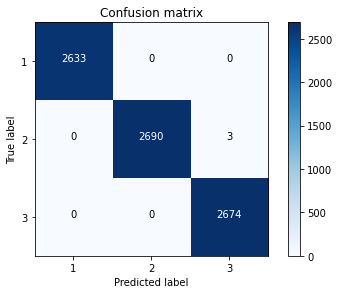

In [25]:
cm_plot_labels = ['1', '2', '3']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix')